## DEL-03 Programming Excercise - Multi-Layer Perceptron - Backward Propagation
### (created by Prof. Dr.-Ing. Christian Bergler & Prof. Dr. Fabian Brunner)

Documentation: **Python-Bibliothek Pandas** - https://pandas.pydata.org/docs/

Documentation: **Numpy** - https://numpy.org/doc/

Documentation: **Sklearn** - https://scikit-learn.org/stable/index.html

Documentation: **Matplotlib** - Documentation: https://matplotlib.org/stable/index.html

Documentation: **Matplotlib** - Graphics Gallery: https://matplotlib.org/2.0.2/gallery.html

Additional Documentation: **Python Tutorial** - https://docs.python.org/3/tutorial/

Additional Documentation: **Matthes Eric, "Python crash course: A hands-on, project-based introduction to programming"**, ISBN: 978-1-59327-603-4, ©2023 no starch press  

In [1]:
import pandas as pd
import numpy as np

### Task DEL-03-1 (Sigmoid Function)

In [95]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derivative(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))

### Task DEL-03-2 (Softmax Activation Function)

In [96]:
def softmax(O):
    O_exp = np.exp(O - np.max(O, axis=1, keepdims=True))
    partition = O_exp.sum(axis=1, keepdims=True)
    return O_exp / partition

### Task DEL-03-3 (Implementation Multi-Layer Perceptron for Classification)

In this and the next exercise, an `Multi-Layer Perceptron (Deep Feed Forward Neural Network)`  for classification is to be implemented from scratch. The topology of the network is to be specified using a list called `nodes_per_layer`. The $i$th entry specifies how many nodes the $i$th layer consists of. The number of layers can be arbitrary. The number of classes corresponds to the number of nodes in the output layer. 

Example: ``nodes_per_layer = [4,5,3]`` would realize a network with 4 nodes in the input layer, 5 nodes in the hidden layer and 3 nodes in the output layer.

Now that forward propagation has already been implemented in the other exercise, model training is to be implemented using the gradient (descent) method. To do this, complete the following class ``DeepFeedForward``. The gradient calculation should be carried out using the backpropagation algorithm presented in the lecture. In addition to the implementation of the ``fit`` method, a modification of the ``forward`` method is recommended by saving the `inputs` and `activations of the hidden layers` calculated during the forward propagation. These are accessed in the course of back propagation.

#### Equation for Backpropagation (Recap!)

- Rekursive Berechnung der Größen $\delta^{[l]}$:

$$\begin{align*}
\delta^{[L]}&=\nabla_{\hat{y}}L \odot ({f^{[L]}})'(z^{[L]})~,\\[0.2cm]
\delta^{[l]}&={\mathbf{W}^{[l+1]}}\delta^{[l+1]}\odot{(f^{[l]}})'(z^{[l]})~,\quad l=L-1,\ldots,1
\end{align*}$$

- Calculation of the partial derivatives according to the weights as a function of the variables $\delta^{[l]}$:

$$\begin{align*}
\frac{\partial L}{\partial b_j^{[l]}}&=\delta^{[l]}_j~,\quad l=1,\ldots,L\\[0.2cm]
\frac{\partial L}{\partial w^{[l]}_{kj}}&=h_k^{[l-1]}\delta_j^{[l]}~,\quad l=1,\ldots,L~.
\end{align*}
$$

In [97]:
import numpy as np

class DeepFeedForward:
    def __init__(self, nodes_per_layer, lr=1.0, num_iter=100):
        self.learning_rate = lr
        self.num_iter = num_iter
        self.n_layers = len(nodes_per_layer)
        self.nodes_per_layer = nodes_per_layer
        self.n_classes = nodes_per_layer[-1]
        self.weight_matrices = []
        self.bias_vectors = []
        self.initialize_weights()

    def initialize_weights(self):
        np.random.seed(42)
        self.weight_matrices = [
            np.random.randn(self.nodes_per_layer[i], self.nodes_per_layer[i - 1])
            for i in range(1, self.n_layers)
        ]
        self.bias_vectors = [
            np.random.randn(self.nodes_per_layer[i], 1)
            for i in range(1, self.n_layers)
        ]

    def forward(self, X):
        layer_inputs = []
        layer_outputs = []
        
        A = X.T
        for i in range(self.n_layers - 2):
            Z = np.dot(self.weight_matrices[i], A) + self.bias_vectors[i]
            A = sigmoid(Z)
            layer_inputs.append(Z)
            layer_outputs.append(A)
        
        Z = np.dot(self.weight_matrices[-1], A) + self.bias_vectors[-1]
        A = softmax(Z)
        layer_inputs.append(Z)
        layer_outputs.append(A)
        
        self.layer_inputs = layer_inputs
        self.layer_outputs = layer_outputs
        
        return A.T

    def compute_loss(self, Y, Y_hat):
        m = Y.shape[0]
        return -np.sum(Y * np.log(Y_hat.T+ 1e-8)) / m

    def backward(self, X, Y):
        m = X.shape[0]
        dW = [0] * (self.n_layers - 1)
        dB = [0] * (self.n_layers - 1)
        
        dZ = self.layer_outputs[-1] - Y
        for i in reversed(range(self.n_layers - 1)):
            dW[i] = np.dot(dZ, self.layer_outputs[i - 1].T) / m if i > 0 else np.dot(dZ, X)
            dB[i] = np.sum(dZ, axis=1, keepdims=True) / m
            
            if i > 0:
                dA_prev = np.dot(self.weight_matrices[i].T, dZ)
                dZ = dA_prev * sigmoid_derivative(self.layer_inputs[i - 1])
        
        return dW, dB

    def update_parameters(self, dW, dB):
        for i in range(self.n_layers - 1):
            self.weight_matrices[i] -= self.learning_rate * dW[i]
            self.bias_vectors[i] -= self.learning_rate * dB[i]

    def fit(self, X, y):
        Y = np.eye(self.n_classes)[y].T
        loss_history = []
        
        for i in range(self.num_iter):
            Y_hat = self.forward(X)
            loss = self.compute_loss(Y, Y_hat)
            loss_history.append(loss)
            
            dW, dB = self.backward(X, Y)
            self.update_parameters(dW, dB)
            
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {loss}")
        
        return loss_history

    def predict(self, X):
        Y_hat = self.forward(X)
        return np.argmax(Y_hat, axis=1)


### Task DEL-03-4 (Testing Implemented Backward Propagation)

- Create a new `DeepFeedForward` object with `4 input neurons, 10 hidden neurons, and 3 output neurons`
- learning rate of `lr=0.2`, and maximum iterations `num_iter=300`
- Initialize `weights` and `biases`
- Train the model using `fit`
- Evaluate using `predict` and `plot` (matplotlib) the `loss` curve

In [110]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = iris.data 
Y = iris.target

In [117]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the DeepFeedForward model
model = DeepFeedForward([4,10,10,3], lr=0.2, num_iter=300)
model.initialize_weights()

In [118]:
# Fit the model
loss_history = model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

Iteration 0, Loss: 224.13353018981948
Iteration 10, Loss: 164.40546595366052
Iteration 20, Loss: 163.02632966837572
Iteration 30, Loss: 162.3402360749208
Iteration 40, Loss: 162.2990518693749
Iteration 50, Loss: 162.57522843365714
Iteration 60, Loss: 163.14201824513515
Iteration 70, Loss: 163.6497003698394
Iteration 80, Loss: 164.6350717193394
Iteration 90, Loss: 165.04167456831098
Iteration 100, Loss: 165.62204064834424
Iteration 110, Loss: 165.7026935902342
Iteration 120, Loss: 165.85167602072386
Iteration 130, Loss: 165.92080333668727
Iteration 140, Loss: 165.94980757969412
Iteration 150, Loss: 165.96871186137352
Iteration 160, Loss: 165.9825752860994
Iteration 170, Loss: 165.99367158866497
Iteration 180, Loss: 166.00285954514553
Iteration 190, Loss: 166.0106795362631
Iteration 200, Loss: 166.01763470954415
Iteration 210, Loss: 166.0243209382132
Iteration 220, Loss: 166.03158401126146
Iteration 230, Loss: 166.04021621209165
Iteration 240, Loss: 166.0478019028168
Iteration 250, Loss:

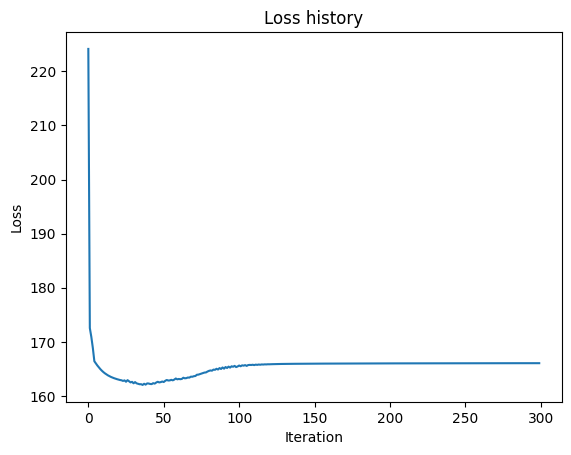

In [119]:
# Plotting the loss history
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

#### Model Training

- Train the `DeepFeedForward` neural network, using the implemented ``fit`` method and `plot` the progression of the loss function over time. How does the curve differ from the curve you observed with the `logistic regression` and the `softmax` regression? Explain!

In [104]:
# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the DeepFeedForward model
nodes_per_layer = [4, 10, 3]
model = DeepFeedForward(nodes_per_layer, lr=0.2, num_iter=300)

# Fit the model
loss_history = model.fit(X_train, y_train)

Iteration 0, Loss: 220.12496992401202
Iteration 10, Loss: 165.08134329209815
Iteration 20, Loss: 165.82458494173986
Iteration 30, Loss: 169.22225287947077
Iteration 40, Loss: 175.69760928393518
Iteration 50, Loss: 178.10240828418569
Iteration 60, Loss: 187.74960082348775
Iteration 70, Loss: 201.0654744629145
Iteration 80, Loss: 223.1867132635684
Iteration 90, Loss: 242.46649731810112
Iteration 100, Loss: 242.28889566524796
Iteration 110, Loss: 272.43014336823234
Iteration 120, Loss: 296.11375180566716
Iteration 130, Loss: 294.74927480122443
Iteration 140, Loss: 362.87846250772856
Iteration 150, Loss: 345.3029101906777
Iteration 160, Loss: 346.07415088452944
Iteration 170, Loss: 343.3280848272734
Iteration 180, Loss: 387.04086659507897
Iteration 190, Loss: 416.9703259282267
Iteration 200, Loss: 389.29542588955036
Iteration 210, Loss: 367.77617327938884
Iteration 220, Loss: 410.19761301128165
Iteration 230, Loss: 461.48512822836466
Iteration 240, Loss: 411.3879355896349
Iteration 250, Lo

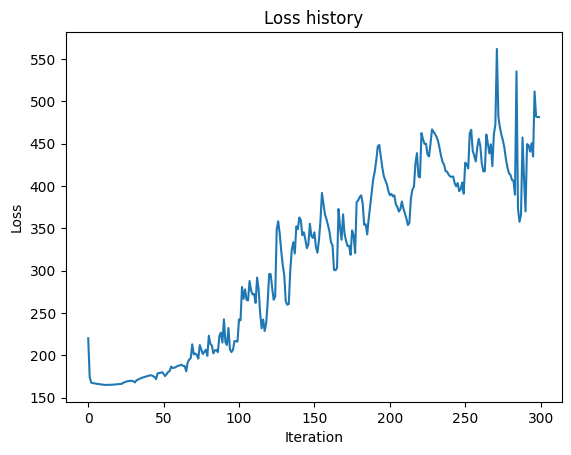